**Table of contents**<a id='toc0_'></a>    
- [MVO 和 BL 模型实现](#toc1_)    
  - [MVO 的数值解和解析解](#toc1_1_)    
    - [MVO 数值解: 给定波动率 求最大收益率](#toc1_1_1_)    
      - [绘制有效前沿](#toc1_1_1_1_)    
    - [MVO 解析解](#toc1_1_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[MVO 和 BL 模型实现](#toc0_)

## <a id='toc1_1_'></a>[MVO 的数值解和解析解](#toc0_)

### <a id='toc1_1_1_'></a>[MVO 数值解: 给定波动率 求最大收益率](#toc0_)

![image.png](attachment:image.png)
![image-2.png](attachment:image-2.png)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from joblib import Parallel, delayed

In [143]:
# 假设我们有四个资产的年化预期回报率和协方差矩阵
returns = np.array([0.12, 0.10, 0.15, 0.08])
#  cov_matrix = np.array([
#     [0.005, -0.010, 0.004, -0.002],
#     [-0.010, 0.040, -0.002, 0.004],
#     [0.004, -0.002, 0.023, 0.002],
#     [-0.002, 0.004, 0.002, 0.010]
# ])

cov_matrix = np.array([
    [0.005, -0.010, 0.004, 0],
    [-0.010, 0.040, -0.002, 0],
    [0.004, -0.002, 0.023, 0],
    [0, 0, 0, 0]
])

individual_volatilities = np.sqrt(np.diag(cov_matrix))

In [126]:
# 定义投资组合预期回报和风险
def portfolio_performance(weights, returns, cov_matrix):
    portfolio_return = np.sum(weights * returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_volatility

# 最大化收益
def maximize_return(weights, returns, cov_matrix):
    # 返回收益的负值，因为 scipy.optimize.minimize 是最小化目标函数
    return -portfolio_performance(weights, returns, cov_matrix)[0]

# 优化函数
def optimize_portfolio_given_volatility(target_volatility, returns, cov_matrix,initial_weights,bounds,options):
    '''
    target_volatility:最大波动率(年化) std
    returns: 各个资产的预期收益率 （年化）
    cov_matrix：资产之间预期收益率的方差协方差矩阵（年化）
    initial_weights：开始搜索时的初始权重
    bounds：每个资产权重的限制，如不允许卖空
    '''
    # 定义约束条件
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # 权重之和等于 1
                {'type': 'ineq', 'fun': lambda x:  target_volatility - portfolio_performance(x, returns, cov_matrix)[1]})  # 波动率小于目标波动率

    # 优化过程，最大化收益
    result = minimize(maximize_return,x0 = initial_weights, args=(returns, cov_matrix), method='SLSQP', bounds=bounds, constraints=constraints, options=options)
    # maximize_return 需要最小化的函数 
    # initial_weights 初始搜索值
    # args 传递给
    return result

In [127]:
# 定义权重的范围 (每个权重在 0 和 1 之间)
bounds = tuple((0, 1) for _ in range(len(returns)))
# 初始权重分配
initial_weights = np.array(len(returns) * [1. / len(returns)])


 print(r)
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.1367513134678099 目标函数 即 最大收益率为 13.6
       x: [ 3.795e-01  3.725e-02  5.832e-01  1.694e-17] 最优解
     nit: 13 优化算法跌打次数
     jac: [-1.200e-01 -1.000e-01 -1.500e-01 -8.000e-02] 目标函数在最优处的雅可比矩阵
    nfev: 66 目标函数调用次数
    njev: 13 雅可比矩阵调用次数

#### <a id='toc1_1_1_1_'></a>[绘制有效前沿](#toc0_)

In [147]:
options = {
    'maxiter': 1000,
    'ftol': 1e-9,
    'disp': False, 
    'eps': 1e-8
}

volatility = np.linspace(0, 0.2, 200)
efficient_returns = np.array([])
successful_volatilities = np.array([])

# 并行计算，能够提升10倍速度
res = Parallel(n_jobs=-1)(delayed(optimize_portfolio_given_volatility)(target_volatility=v, returns=returns, cov_matrix = cov_matrix, initial_weights=initial_weights, bounds=bounds, options = options) for v in volatility)



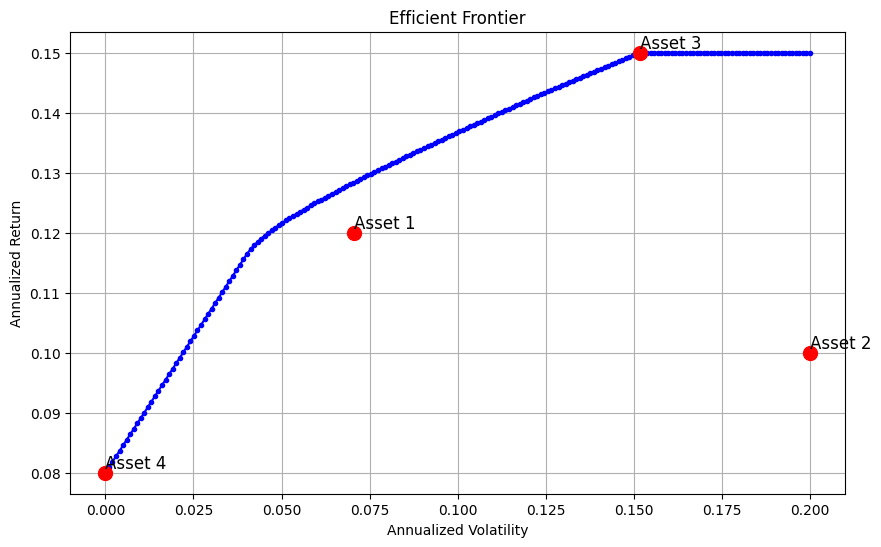

In [148]:
for res, vol  in zip(res,volatility):
    if res.success:
        efficient_returns = np.append(efficient_returns,-res.fun)
        successful_volatilities = np.append(successful_volatilities,vol)
    else:
        # 优化失败
        print(f"Optimization failed for target volatility {vol}")

# 绘制有效前沿
plt.figure(figsize=(10, 6))
plt.plot(successful_volatilities, efficient_returns, 'b-', marker='o', markersize=3)

# 绘制单个资产点
for i in range(len(returns)):
    plt.plot(individual_volatilities[i], returns[i], 'ro', markersize=10)
    plt.text(individual_volatilities[i], returns[i], f'Asset {i+1}', fontsize=12, verticalalignment='bottom')

plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.title('Efficient Frontier')
plt.grid(True)
plt.show()

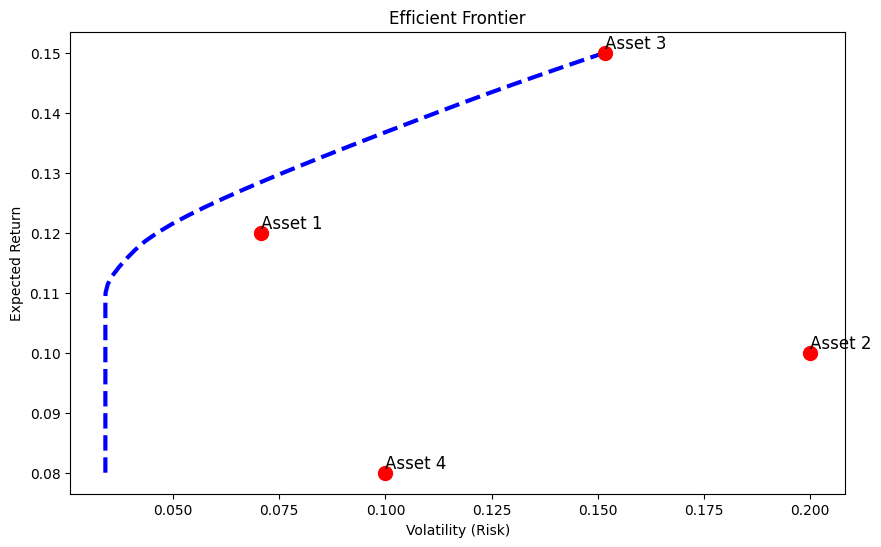

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from joblib import Parallel, delayed

# 假设我们有四个资产的年化预期回报率和协方差矩阵
returns = np.array([0.12, 0.10, 0.15, 0.08])
cov_matrix = np.array([
    [0.005, -0.010, 0.004, -0.002],
    [-0.010, 0.040, -0.002, 0.004],
    [0.004, -0.002, 0.023, 0.002],
    [-0.002, 0.004, 0.002, 0.010]
])

# 定义投资组合预期回报和风险
def portfolio_performance(weights, returns, cov_matrix):
    portfolio_return = np.sum(weights * returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_volatility

# 最小化风险的目标函数
def minimize_volatility(weights, returns, cov_matrix):
    return portfolio_performance(weights, returns, cov_matrix)[1]

# 约束条件和初始权重
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(len(returns)))
initial_weights = np.array(len(returns) * [1. / len(returns)])

# 优化函数
def optimize_portfolio(target_return, returns, cov_matrix):
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'ineq', 'fun': lambda x: portfolio_performance(x, returns, cov_matrix)[0] - target_return})
    result = minimize(minimize_volatility, initial_weights, args=(returns, cov_matrix), method='SLSQP', bounds=bounds, constraints=constraints)
    return result.fun

# 计算有效前沿
frontier_returns = np.linspace(0.08, 0.15, 50)

# 使用joblib并行计算有效前沿
frontier_volatility = Parallel(n_jobs=-1)(delayed(optimize_portfolio)(target_return, returns, cov_matrix) for target_return in frontier_returns)

# 绘制有效前沿
plt.figure(figsize=(10, 6))
plt.plot(frontier_volatility, frontier_returns, 'b--', linewidth=3)
individual_volatilities = np.sqrt(np.diag(cov_matrix))
for i in range(len(returns)):
    plt.plot(individual_volatilities[i], returns[i], 'ro', markersize=10)
    plt.text(individual_volatilities[i], returns[i], f'Asset {i+1}', fontsize=12, verticalalignment='bottom')

plt.title('Efficient Frontier')
plt.xlabel('Volatility (Risk)')
plt.ylabel('Expected Return')
plt.show()


### <a id='toc1_1_2_'></a>[MVO 解析解](#toc0_)